In [3]:
import os
import glob
import re
import shutil
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import pandas as pd
from PIL import Image

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [4]:
def analyze_result(path):
    pred=pd.read_csv(path)
    pred.rename(columns={'id': 'pid'}, inplace=True)
    lab=pd.read_csv("/mnt/idms/home/andor/stats.csv")
    merged=pred.merge(lab,on="pid")
    merged.rename(columns={'cancer_x': 'pred', 'cancer_y': 'lab'}, inplace=True)
    summary=merged[['pid','pred','lab']]
    summary['pred_bool']=np.where(summary['pred']>0.5,1,0)
    correct=np.sum(summary['lab']==summary['pred_bool'])
    case_cnt=len(summary)
    print(f"There are {correct} correct prediction out of {case_cnt} CTs, giving {correct*100/case_cnt}% accuracy.")
    
    auc = roc_auc_score(summary['lab'], summary['pred'])
    fpr, tpr, _ = roc_curve(summary['lab'], summary['pred'])
    print(f"The AUC is {auc}.")
    pyplot.plot(fpr, tpr, marker='.', label='Lung Cancer')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()

In [55]:
def compare_results(pred_paths, lab_path="/mnt/idms/home/andor/stats.csv"):
    
    preds=[pd.read_csv(path).rename(columns={'id': 'pid', 'cancer':f'cancer_prediction{idx}'}) for idx,path in enumerate(pred_paths)]
    lab=pd.read_csv(lab_path).rename(columns={'cancer':'cancer_label'})  
    merged=lab
    
    for pred in preds:
        merged=merged.merge(pred, on="pid")
    columns_needed=['pid','cancer_label']+[f'cancer_prediction{idx}' for idx in range(len(preds))]
    summary=merged[columns_needed]
    for idx in range(len(preds)):
        summary[f'prediction_bool{idx}']=np.where(summary[f'cancer_prediction{idx}']>0.5,1,0)
    
    corrects=[np.sum(summary['cancer_label']==summary[f'prediction_bool{idx}']) for idx in range(len(preds))]
    case_cnt=len(summary)
    for idx, correct in enumerate(corrects):
        print(f"With method {idx}, there are {correct} correct prediction out of {case_cnt} CTs, giving {correct*100/case_cnt}% accuracy.")
    print('\n')
    aucs = [roc_auc_score(summary['cancer_label'], summary[f'cancer_prediction{idx}']) for idx in range(len(preds))]
    fprs_and_tprs = [roc_curve(summary['cancer_label'], summary[f'cancer_prediction{idx}']) for idx in range(len(preds))]
    for idx, auc in enumerate(aucs):
        print(f"The AUC of method {idx} is {auc}.")
    
    fig, axs=plt.subplots(nrows=len(preds))
    for idx, (fpr, tpr, _) in enumerate(fprs_and_tprs): 
        axs[idx].plot(fpr, tpr)
        axs[idx].set_title(f'ROC-AUC curve of method {idx}')
        axs[idx].set_xlabel('False Positive Rate')
        axs[idx].set_ylabel('True Positive Rate')
    plt.subplots_adjust(hspace=1.0)
    plt.show()

/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


With method 0, there are 32 correct prediction out of 55 CTs, giving 58.18181818181818% accuracy.
With method 1, there are 28 correct prediction out of 55 CTs, giving 50.90909090909091% accuracy.


The AUC of method 0 is 0.8003003003003004.
The AUC of method 1 is 0.7687687687687688.


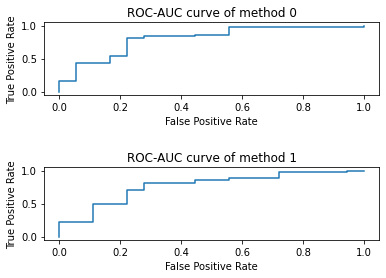

In [56]:
compare_results(["/mnt/idms/home/andor/prediction-original.csv","/mnt/idms/home/andor/prediction-super.csv"])

In [34]:
merged

,Unnamed: 0,pid,num_nods,cancer_lab,cancer_pred0,cancer_pred1
0,1,LIDC-IDRI-0831,1,0,0.094139,0.308166
1,2,LIDC-IDRI-0564,0,0,0.009711,0.029639
2,3,LIDC-IDRI-0723,4,1,0.050270,0.050638
3,5,LIDC-IDRI-0135,19,1,0.228096,0.066309
4,6,LIDC-IDRI-0415,24,1,0.690610,0.220155
5,8,LIDC-IDRI-0601,17,1,0.399131,0.194084
6,9,LIDC-IDRI-0229,25,1,0.975891,0.812041
7,10,LIDC-IDRI-0577,15,1,0.409251,0.339624
8,11,LIDC-IDRI-0022,1,0,0.924066,0.618591
9,12,LIDC-IDRI-0055,20,1,0.951264,0.522116


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


There are 49 correct prediction out of 80 CTs, giving 61.25% accuracy.
The AUC is 0.849242922975642.


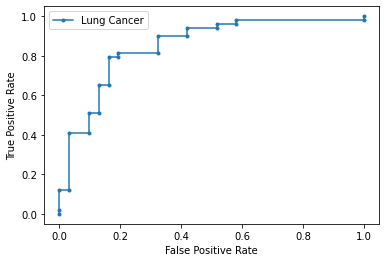

In [5]:
analyze_result("/mnt/idms/home/andor/prediction-original.csv")

/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


There are 28 correct prediction out of 55 CTs, giving 50.90909090909091% accuracy.
The AUC is 0.7687687687687688.


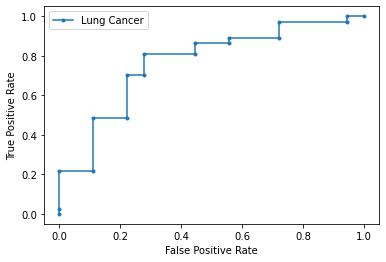

In [6]:
analyze_result("/mnt/idms/home/andor/prediction-super.csv")